In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.datasets import fetch_dataset

from skforecast.recursive import ForecasterRecursiveMultiSeries
from sklearn.preprocessing import StandardScaler
from skforecast.preprocessing import RollingFeatures
from skforecast.model_selection import (TimeSeriesFold, backtesting_forecaster_multiseries, bayesian_search_forecaster_multiseries, 
backtesting_forecaster_multiseries )
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

In [181]:
df = fetch_dataset(name="australia_tourism", raw = True)
df

australia_tourism
-----------------
Quarterly overnight trips (in thousands) from 1998 Q1 to 2016 Q4 across
Australia. The tourism regions are formed through the aggregation of Statistical
Local Areas (SLAs) which are defined by the various State and Territory tourism
authorities according to their research and marketing needs.
Wang, E, D Cook, and RJ Hyndman (2020). A new tidy data structure to support
exploration and modeling of temporal data, Journal of Computational and
Graphical Statistics, 29:3, 466-478, doi:10.1080/10618600.2019.1695624.
Shape of the dataset: (24320, 5)


,date_time,Region,State,Purpose,Trips
0,1998-01-01,Adelaide,South Australia,Business,135.077690
1,1998-04-01,Adelaide,South Australia,Business,109.987316
2,1998-07-01,Adelaide,South Australia,Business,166.034687
3,1998-10-01,Adelaide,South Australia,Business,127.160464
4,1999-01-01,Adelaide,South Australia,Business,137.448533
...,...,...,...,...,...
24315,2016-10-01,Yorke Peninsula,South Australia,Visiting,33.672151
24316,2017-01-01,Yorke Peninsula,South Australia,Visiting,46.223014
24317,2017-04-01,Yorke Peninsula,South Australia,Visiting,50.582837
24318,2017-07-01,Yorke Peninsula,South Australia,Visiting,27.766728


In [182]:
df.describe()

,Trips
count,24320.000000
mean,70.896448
std,118.763185
min,0.000000
25%,7.223910
50%,28.134538
75%,78.154410
max,985.278401


In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24320 entries, 0 to 24319
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date_time  24320 non-null  object 
 1   Region     24320 non-null  object 
 2   State      24320 non-null  object 
 3   Purpose    24320 non-null  object 
 4   Trips      24320 non-null  float64
dtypes: float64(1), object(4)
memory usage: 950.1+ KB


In [184]:
# Check for NAs
df.isnull().sum()

date_time    0
Region       0
State        0
Purpose      0
Trips        0
dtype: int64

In [185]:
# Convert date_time col to datetime type
df["date_time"] = pd.to_datetime(df["date_time"])

In [186]:
# Create a dataframe with one column per Region which gives the total number of Trips for each date.
df = df.groupby(["date_time", "Region"])["Trips"].sum().unstack()

In [187]:
# Ensure the index is date_time and resampled to quarterly start QS
df = df.asfreq('QS')

In [188]:
df

Region,Adelaide,Adelaide Hills,Alice Springs,Australia's Coral Coast,Australia's Golden Outback,Australia's North West,Australia's South West,Ballarat,Barkly,Barossa,...,Sunshine Coast,Sydney,The Murray,Tropical North Queensland,Upper Yarra,Western Grampians,Whitsundays,Wilderness West,Wimmera,Yorke Peninsula
date_time,,,,,,,,,,,,,,,,,,,,,
1998-01-01,658.553895,9.798630,20.207638,132.516409,161.726948,120.775450,474.858729,182.239341,18.465206,46.796083,...,742.602299,2288.955629,356.500087,220.915346,102.791022,86.996591,60.226649,63.335097,18.804743,160.681637
1998-04-01,449.853935,26.066952,56.356223,172.615378,164.973780,158.404387,411.622281,137.566539,7.510969,49.428717,...,609.883333,1814.459480,312.291189,253.097616,74.855136,84.939977,106.190848,42.607076,52.482311,104.324252
1998-07-01,592.904597,26.491072,110.918441,173.904335,206.879934,184.619035,360.039657,117.642761,43.565625,29.743302,...,615.306331,1989.731939,376.718698,423.506735,59.465405,79.974884,81.771005,18.851214,35.657551,68.996468
1998-10-01,524.242760,27.256859,40.868270,207.002571,198.509591,138.878263,462.620050,136.072724,29.359239,78.193066,...,684.430239,2150.913627,336.367694,283.694451,35.238855,116.235617,105.600143,50.450965,27.204455,103.340264
1999-01-01,548.394105,13.772975,48.368038,198.856638,140.213443,103.337122,562.974629,156.456242,6.341997,35.277910,...,842.167418,1779.286905,323.418472,194.509904,67.823457,101.765635,111.504972,59.888003,50.219851,146.658290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-10-01,634.371320,52.394264,40.294387,256.812239,269.929128,316.206762,755.086257,157.294300,16.429513,55.635552,...,926.126074,2369.815703,221.750120,479.353000,59.649892,102.374415,88.041287,30.865882,25.709937,83.928227
2017-01-01,708.331889,36.969343,47.996947,241.954414,225.966191,226.548225,919.869186,199.279617,17.943822,41.424295,...,891.201239,2426.298897,271.653194,305.324070,114.135901,92.961571,113.457701,59.447800,62.933796,150.263258
2017-04-01,676.453064,55.755987,85.128262,223.855848,256.353973,285.790089,764.152839,209.912525,44.524176,73.845843,...,764.433935,2446.157160,317.345092,415.729931,93.991505,71.596771,148.480575,28.810246,41.844623,125.931322


In [189]:
# Remove special characters from the column names
import re

df = df.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x))

In [190]:
regions = df.columns

### EDA

In [191]:
# Number of data points in the time series, the start date, and the end date
print(len(df.index), "time points")
print("starting", df.index[0])
print("ending", df.index.max())

80 time points
starting 1998-01-01 00:00:00
ending 2017-10-01 00:00:00


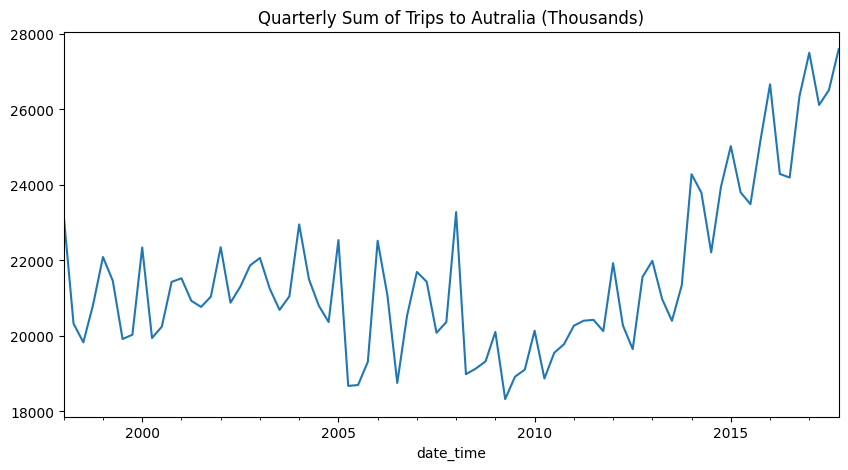

In [192]:
fig, ax = plt.subplots(figsize=[10, 5])
df.sum(axis=1).plot(ax=ax)
ax.set_title("Quarterly Sum of Trips to Autralia (Thousands)")
plt.show()

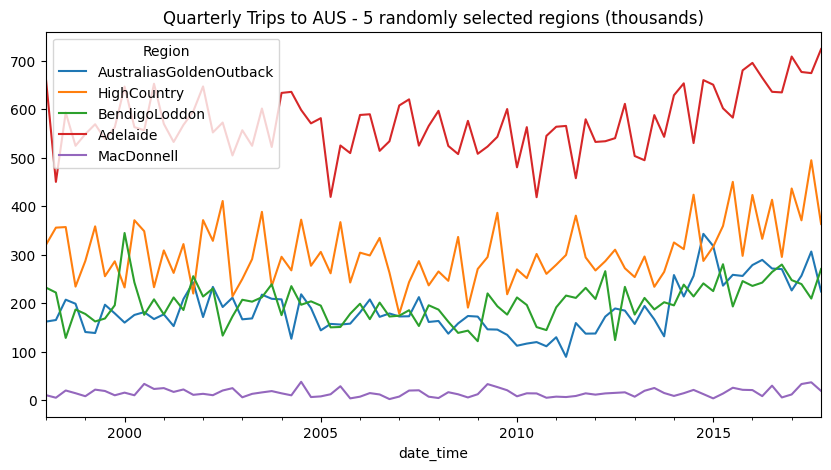

In [193]:
fig, ax = plt.subplots(figsize=[10, 5])
df.sample(n=5, axis=1, random_state=42).plot(ax=ax)
ax.set_title("Quarterly Trips to AUS - 5 randomly selected regions (thousands)")
plt.show()

In [194]:
# Quarter feature
df["Quarter"] = df.index.quarter

### Forecasting

In [195]:
target_cols = regions

exog_cols = ["Quarter"]

In [196]:
# 8 forecast horizon
steps = 8

In [197]:
# df for future exog variable
future_start_date = df.index.max() + pd.DateOffset(months=3)
future_dates = pd.date_range(start=future_start_date, freq = "QS", periods = steps+1)

In [198]:
future_exog = pd.DataFrame(index=future_dates)
future_exog['Quarter'] = future_exog.index.quarter

In [199]:
future_exog

,Quarter
2018-01-01,1
2018-04-01,2
2018-07-01,3
2018-10-01,4
2019-01-01,1
2019-04-01,2
2019-07-01,3
2019-10-01,4
2020-01-01,1


In [200]:
# Weight function to discount past values
def custom_weights(index):
    """
    Linearly decrease the weight going back in time.
    """
    num_time_points = len(index)
    weights = np.linspace(start=0, stop=1, num=num_time_points)
    return weights

In [201]:
forecaster = ForecasterRecursiveMultiSeries(
    regressor=LGBMRegressor(random_state=42),
    lags = 4,
    window_features = RollingFeatures(stats=['mean', 'std','mean', 'std'], window_sizes=[4,4,12,12]),
    transformer_series=StandardScaler(),
    transformer_exog=StandardScaler(),
    weight_func = custom_weights
)

In [202]:
forecaster

============================== 
ForecasterRecursiveMultiSeries 
============================== 
Regressor: LGBMRegressor 
Lags: [1 2 3 4] 
Window features: ['roll_mean_4', 'roll_std_4', 'roll_mean_12', 'roll_std_12'] 
Window size: 12 
Series encoding: ordinal 
Series names (levels): None 
Exogenous included: False 
Exogenous names: None 
Transformer for series: StandardScaler() 
Transformer for exog: StandardScaler() 
Weight function included: True 
Series weights: None 
Differentiation order: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0} 
fit_kwargs: {} 
Creation date: 2025-03-02 16:55:06 
Last fit date: None 
Skforecast version: 0.14.0 
Python version: 3.12.8 
Forecaster id: None

In [203]:
forecaster.fit(
    series = df[target_cols],
    exog = df[exog_cols],
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2121
[LightGBM] [Info] Number of data points in the train set: 5168, number of used features: 10
[LightGBM] [Info] Start training from score 0.123730


In [204]:
forecaster

============================== 
ForecasterRecursiveMultiSeries 
============================== 
Regressor: LGBMRegressor 
Lags: [1 2 3 4] 
Window features: ['roll_mean_4', 'roll_std_4', 'roll_mean_12', 'roll_std_12'] 
Window size: 12 
Series encoding: ordinal 
Series names (levels): 
    Adelaide, AdelaideHills, AliceSprings, AustraliasCoralCoast,
    AustraliasGoldenOutback, AustraliasNorthWest, AustraliasSouthWest, Ballarat,
    Barkly, Barossa, BendigoLoddon, BlueMountains, Brisbane, Bundaberg,
    Canberra, CapitalCountry, CentralCoast, CentralHighlands, CentralMurray,
    CentralNSW, CentralQueensland, ClareValley, DarlingDowns, Darwin, EastCoast,
    ..., MurrayEast, Murraylands, NewEnglandNorthWest, NorthCoastNSW, NorthWest,
    Northern, Outback, OutbackNSW, Peninsula, PhillipIsland, Riverina,
    Riverland, SnowyMountains, SouthCoast, SpaCountry, SunshineCoast, Sydney,
    TheMurray, TropicalNorthQueensland, UpperYarra, WesternGrampians,
    Whitsundays, WildernessWest, Wimmera, YorkePeninsula 
Exogenous included: True 
Exogenous names: Quarter 
Transformer for series: StandardScaler() 
Transformer for exog: StandardScaler() 
Weight function included: True 
Series weights: None 
Differentiation order: None 
Training range: 
    'Adelaide': ['1998-01-01', '2017-10-01'], 'AdelaideHills': ['1998-01-01',
    '2017-10-01'], 'AliceSprings': ['1998-01-01', '2017-10-01'],
    'AustraliasCoralCoast': ['1998-01-01', '2017-10-01'],
    'AustraliasGoldenOutback': ['1998-01-01', '2017-10-01'], ...,
    'WesternGrampians': ['1998-01-01', '2017-10-01'], 'Whitsundays':
    ['1998-01-01', '2017-10-01'], 'WildernessWest': ['1998-01-01',
    '2017-10-01'], 'Wimmera': ['1998-01-01', '2017-10-01'], 'YorkePeninsula':
    ['1998-01-01', '2017-10-01'] 
Training index type: DatetimeIndex 
Training index frequency: QS-JAN 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0} 
fit_kwargs: {} 
Creation date: 2025-03-02 16:55:06 
Last fit date: 2025-03-02 16:55:08 
Skforecast version: 0.14.0 
Python version: 3.12.8 
Forecaster id: None

In [205]:
forecast = forecaster.predict(
    steps=steps,
    exog=future_exog,
)

In [206]:
forecast

,Adelaide,AdelaideHills,AliceSprings,AustraliasCoralCoast,AustraliasGoldenOutback,AustraliasNorthWest,AustraliasSouthWest,Ballarat,Barkly,Barossa,...,SunshineCoast,Sydney,TheMurray,TropicalNorthQueensland,UpperYarra,WesternGrampians,Whitsundays,WildernessWest,Wimmera,YorkePeninsula
2018-01-01,708.216622,46.673220,47.037155,267.967631,242.824985,282.459442,839.155866,189.200068,22.450593,46.081220,...,916.867811,2449.872703,260.897906,408.223041,98.894714,87.227188,113.829045,57.888980,41.333317,142.531874
2018-04-01,705.493277,51.505909,76.343186,276.074056,308.617136,306.605434,722.229268,160.442172,29.395320,60.571954,...,837.793448,2430.672446,284.788004,404.751546,68.605149,66.406183,117.220122,33.828170,36.733040,117.399464
2018-07-01,683.907978,45.962716,78.910011,274.107748,271.749003,308.682007,549.136246,152.116017,21.603579,47.912025,...,857.279974,2423.068964,268.914060,544.576804,43.804899,74.259125,119.120421,24.117031,41.675293,102.862806
2018-10-01,705.566252,52.328718,60.243229,284.020046,263.597776,302.232611,713.326273,185.163130,18.429504,51.866766,...,929.558419,2433.680784,280.960553,528.020028,78.779162,88.888688,151.462799,37.976868,37.993266,140.961799
2019-01-01,697.847828,54.299004,47.763173,272.404332,288.743095,289.201515,841.224067,196.325878,23.833901,50.347349,...,913.707782,2369.529758,299.216842,394.861732,99.394307,91.621399,126.024850,59.668651,38.782009,152.453968
2019-04-01,688.999832,56.098500,65.471655,275.484201,266.459750,289.262606,807.857858,176.311182,31.524962,52.528357,...,866.424002,2385.149700,291.302875,405.008727,65.546424,69.775187,132.807996,36.458677,36.720134,122.221484
2019-07-01,691.072107,54.919576,80.103006,275.323265,265.577766,294.759680,617.558318,172.838878,23.529168,54.247173,...,885.554651,2420.373647,302.822757,525.318845,54.333047,77.282365,130.757931,18.422043,34.306249,107.507358
2019-10-01,687.887474,55.934613,73.318461,282.044024,282.252048,313.248180,764.887298,185.472606,19.375432,56.288092,...,946.262811,2488.465144,302.853901,528.009546,88.490935,90.416630,132.770421,40.921190,37.107867,128.290090


In [207]:
df1 = df.drop(columns= ['Quarter'])

In [208]:
df1 = df.sample(n=5, axis=1, random_state=42)

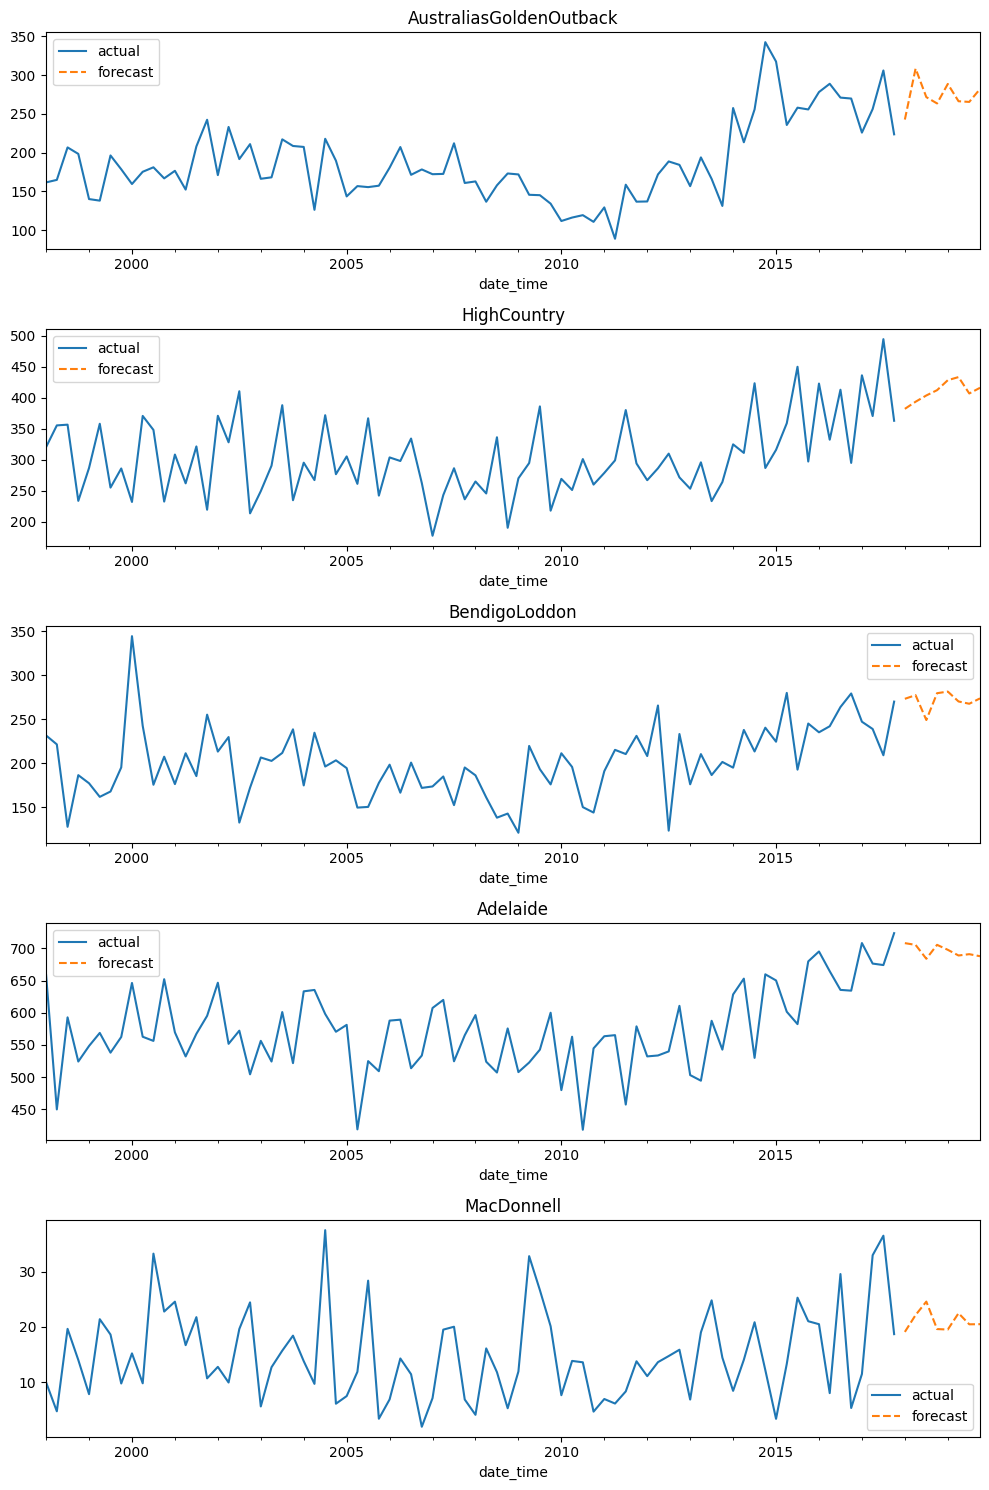

In [209]:
# Plot 5 sampled regions
fig, axs = plt.subplots(nrows = len(df1.columns), figsize = [10, 3 * len(df1.columns)])
for i in range(len(df1.columns)):
    region = df1.columns[i]
    ax = axs[i]
    df1[region].plot(ax=ax)
    forecast[region].plot(ax=ax, linestyle="--")
    ax.legend(["actual", "forecast"])
    ax.set_title(f"{region}")
plt.tight_layout()

### Backtesting (cross validation)

In [217]:
#train = df.loc[:'2015-10-01']
cv = TimeSeriesFold(
    steps = steps,
    initial_train_size = 40,
    refit = True,
    fixed_train_size= False
)
metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
    forecaster            = forecaster,
    series                = df[target_cols],
    exog                  = df[exog_cols],
    cv                    = cv,
    metric                = "mean_absolute_error",
    add_aggregated_metric = False,
    n_jobs                = "auto",
    verbose               = True,
    show_progress         = True,
    suppress_warnings     = True
)

Information of folds
--------------------
Number of observations used for initial training: 40
Number of observations used for backtesting: 40
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 8
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   1998-01-01 00:00:00 -- 2007-10-01 00:00:00  (n=40)
    Validation: 2008-01-01 00:00:00 -- 2009-10-01 00:00:00  (n=8)
Fold: 1
    Training:   1998-01-01 00:00:00 -- 2009-10-01 00:00:00  (n=48)
    Validation: 2010-01-01 00:00:00 -- 2011-10-01 00:00:00  (n=8)
Fold: 2
    Training:   1998-01-01 00:00:00 -- 2011-10-01 00:00:00  (n=56)
    Validation: 2012-01-01 00:00:00 -- 2013-10-01 00:00:00  (n=8)
Fold: 3
    Training:   1998-01-01 00:00:00 -- 2013-10-01 00:00:00  (n=64)
    Validation: 2014-01-01 00:00:00 -- 2015-10-01 00:00:00  (n=8)
Fold: 4
    Training:   1998-01-01 00:00:00 -- 2015-10-01 00:00:00  (n=72)
    Validation: 2016-01-01 00:00:00 

  0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2121
[LightGBM] [Info] Number of data points in the train set: 2736, number of used features: 10
[LightGBM] [Info] Start training from score -0.120794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2121
[LightGBM] [Info] Number of data points in the train set: 3344, number of used features: 10
[LightGBM] [Info] Start training from score -0.131708
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2121
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 10
[LightGBM] [Info] Start trai

In [218]:
display(metrics_levels)

,levels,mean_absolute_error
0,Adelaide,59.661389
1,AdelaideHills,10.087824
2,AliceSprings,14.134995
3,AustraliasCoralCoast,44.844382
4,AustraliasGoldenOutback,44.412877
...,...,...
71,WesternGrampians,16.391021
72,Whitsundays,26.737594
73,WildernessWest,8.457258
74,Wimmera,10.041264


In [219]:
metrics_levels['mean_absolute_error'].mean()

39.5414876111621

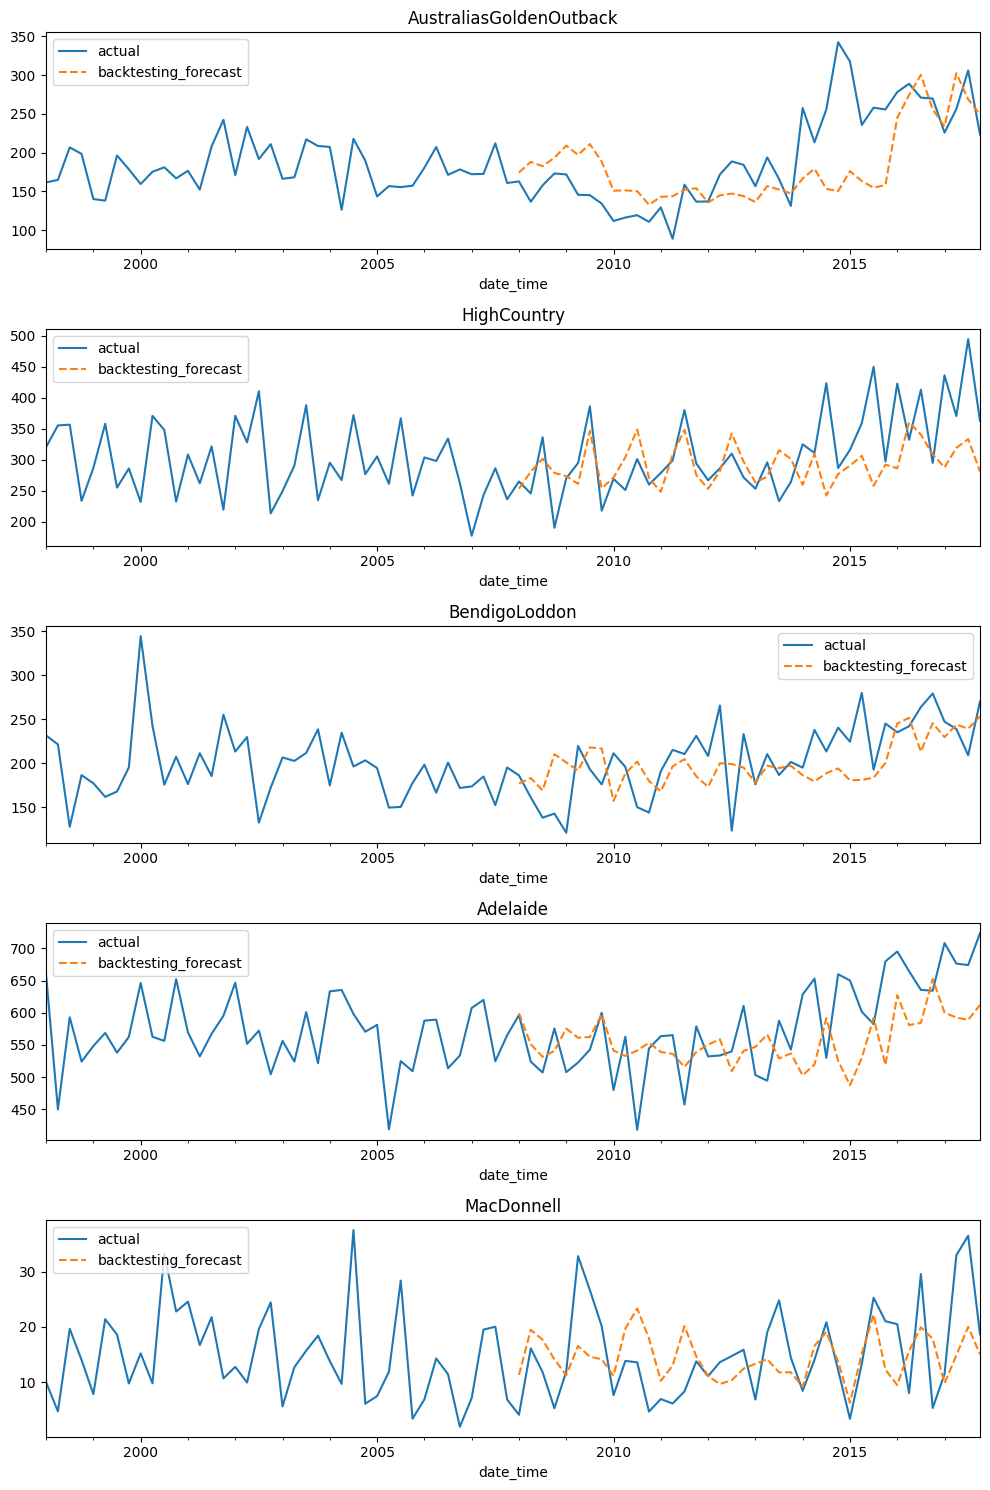

In [220]:
fig, axs = plt.subplots(nrows = len(df1.columns), figsize = [10, 3 * len(df1.columns)])
for i in range(len(df1.columns)):
    region = df1.columns[i]
    ax = axs[i]
    df1[region].plot(ax=ax)
    backtest_predictions[region].plot(ax=ax, linestyle="--")
    ax.legend(["actual", "backtesting_forecast"])
    ax.set_title(f"{region}")
plt.tight_layout()

- In conclusion, our global model was able to predict the quarterly overnight trips in Australia successfully. On average, our predictions were off by 39.5K trips for the 40 quarterly forecasts it had made through backtesting method.